In [8]:
import os
import tarfile
import urllib

DL_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DL_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()
!pwd

/home/matt/portfolio/practice_projects/notebooks


In [10]:
import pandas as pd

housing = pd.read_csv('datasets/housing/housing.csv')

In [169]:
# housing EDA

# 20640 entries, 10 features
# 207 missing values for total bedrooms
# total rooms and total bedrooms seems to have a mix of count and square footage
# all numeric except ocean_proximity
    # 

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

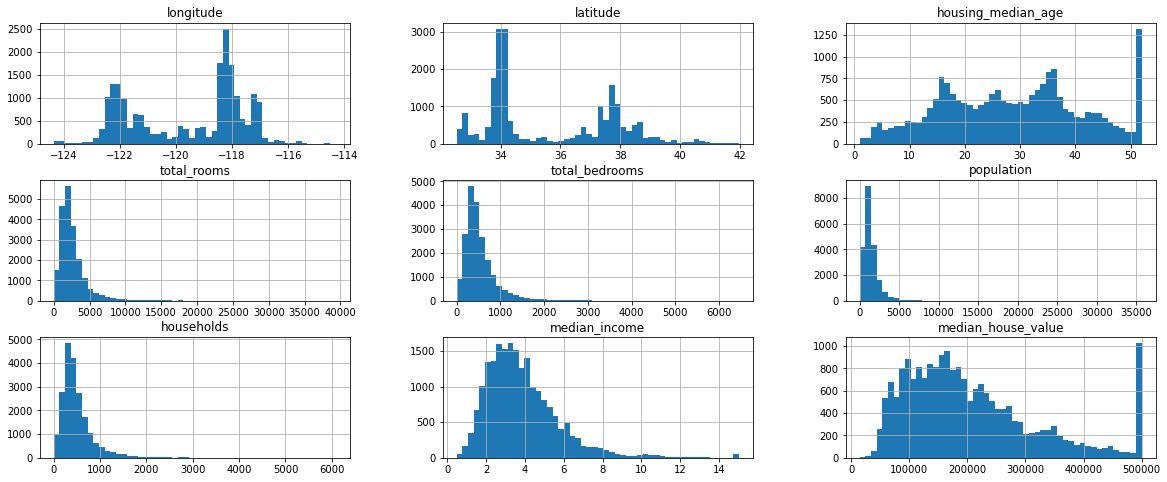

In [24]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=[20,8])

In [ ]:
# housing_median_age and median_housing_value are clearly capped
    # median_income too, but not as badly
    # capped median_housing_value would be a big problem if we want our model to accurately predict values >500k
# median_income is a transformed value, roughly 1 = $10k
# many features are heavily positive/right skewed, and therefore may benefit from a transformation

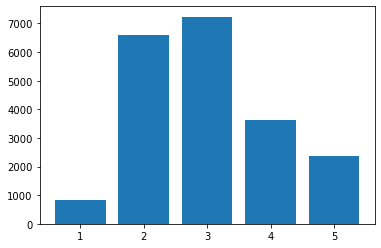

In [49]:
# normal train test split procedure:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2)

# however, we know that the median_income is a vital feature for accurate prediction
# therefore it will pay off to stratifiy our split on median_income

import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

fig, ax = plt.subplots()
ax.bar(housing['income_cat'].value_counts().index, housing['income_cat'].value_counts().values)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [62]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.043120,8.272506,-0.243309
2,0.318847,0.318798,0.322190,1.048473,-0.015195
3,0.350581,0.350533,0.338421,-3.468767,-0.013820
4,0.176308,0.176357,0.181928,3.187689,0.027480
5,0.114438,0.114583,0.114341,-0.084674,0.127011


In [66]:
# disparity in proprotions for stratified vs random error is substantial

# for set_ in (strat_train_set, strat_test_set):
#     set_.drop(columns = 'income_cat', inplace = True)

housing = strat_train_set.copy()

Text(0.5, 1.0, 'Population and Income for California Housing Districts')

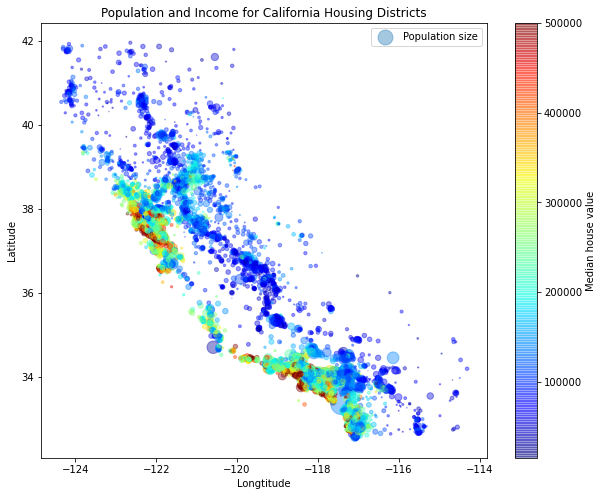

In [119]:
fig, ax = plt.subplots(figsize = [10,8])
sc = ax.scatter(housing['longitude'], housing['latitude'], alpha=0.4, 
    s = housing['population'] / 80,
    label='Population size',
    c = housing['median_house_value'],
    cmap = 'jet',)
plt.colorbar(sc, label = 'Median house value')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longtitude')
ax.legend()
ax.set_title('Population and Income for California Housing Districts')

# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
#              s=housing["population"]/100, label="population", figsize=(10,7),
#              c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
#              sharex=False)
# plt.legend()
# save_fig("housing_prices_scatterplot")

In [146]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

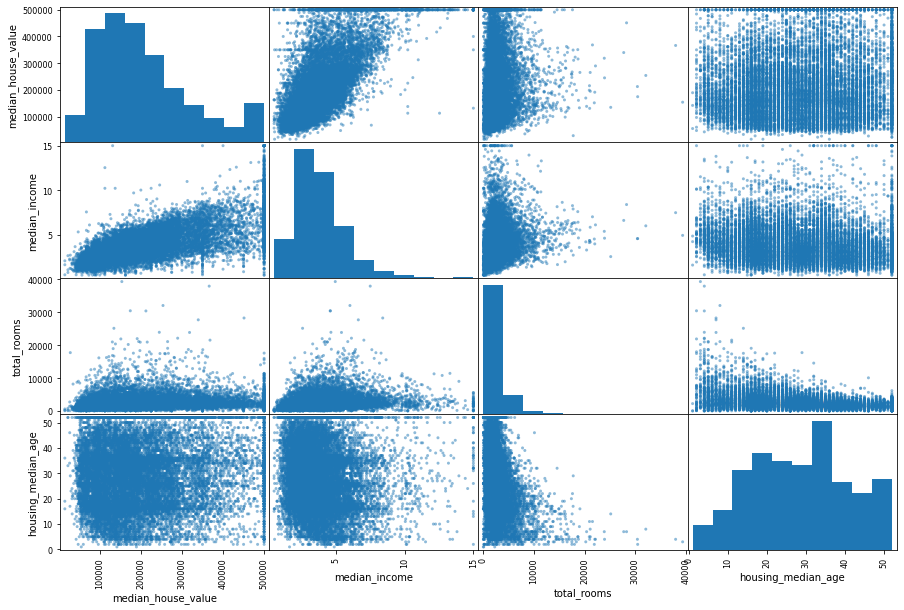

In [145]:
# based on the above values, let's pick out the most promising features

from pandas.plotting import scatter_matrix

features = corr_matrix['median_house_value'].sort_values(ascending=False).index[:4]
scatter_matrix(housing[features], figsize = [15,10]);

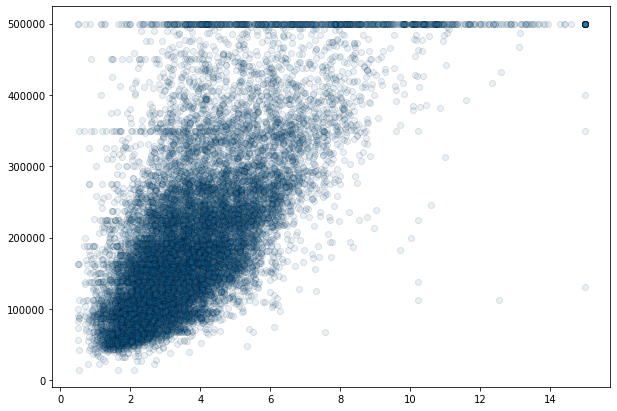

In [152]:
# median_income is indeed the most promising feature, let's look closely

fig, ax = plt.subplots(figsize=[10,7])
ax.scatter(housing['median_income'],housing['median_house_value'], alpha = 0.1, ec='black')

In [ ]:
# horizontal lines at 500k, 450k, 350k, 220k might be artifacts that distort predictions

In [166]:
# feature extraction attempts

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64


,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16354.000000,16512.000000
mean,206990.920724,5.440341,0.212878,3.096437
std,115703.014830,2.611712,0.057379,11.584826
min,14999.000000,1.130435,0.100000,0.692308
25%,119800.000000,4.442040,0.175304,2.431287
50%,179500.000000,5.232284,0.203031,2.817653
75%,263900.000000,6.056361,0.239831,3.281420
max,500001.000000,141.909091,1.000000,1243.333333


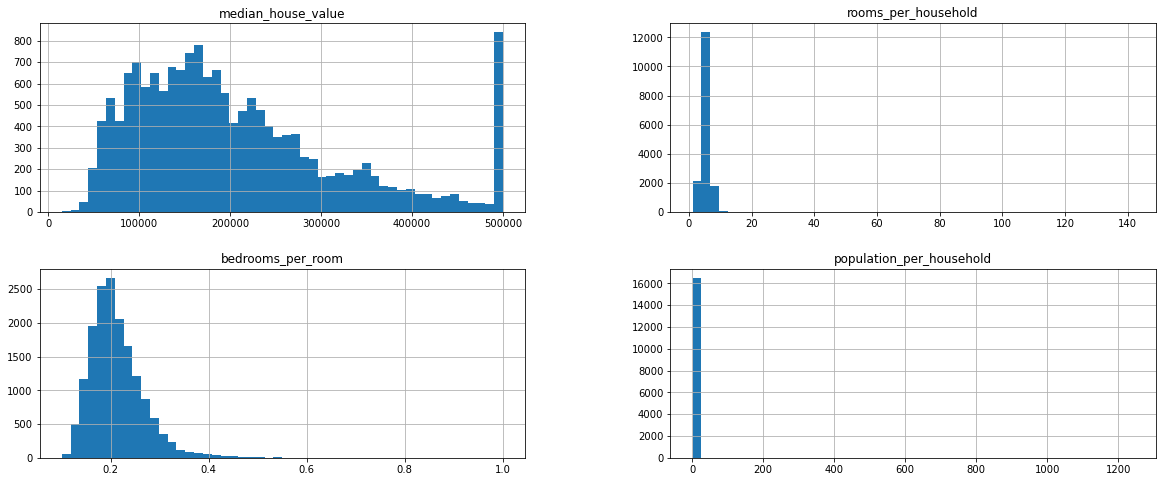

In [170]:
features_updated = ['median_house_value', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']

housing[features_updated].hist(bins=50, figsize=[20,8])
housing[features_updated].describe()

(0.0, 10.0)

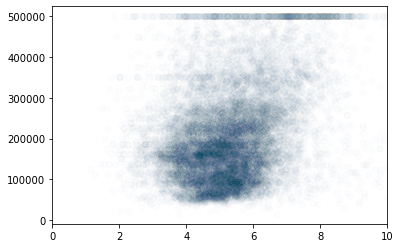

In [182]:
# clearly there are outliers among the extracted features, e.g. 130 room household worth
# 180k?

fig, ax = plt.subplots()
ax.scatter(housing['rooms_per_household'], housing['median_house_value'], alpha=0.01, ec='black')
# ax.scatter(housing['population_per_household'], housing['median_house_value'], alpha=0.1)
ax.set_xlim(0,10)

In [183]:
# drop labels for training set

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [190]:
# impute median for missing numeric values

# housing_num = housing.drop(columns = 'ocean_proximity')

# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="median")
# imputer.fit(housing_num)

# X = imputer.transform(housing_num)


In [201]:
# one hot encode categorical features

# housing_cat = housing[["ocean_proximity"]]

# from sklearn.preprocessing import OneHotEncoder
# cat_encoder = OneHotEncoder()
# housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# # cat_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [211]:
# feature extraction transformer for pipeline

from sklearn.base import BaseEstimator, TransformerMixin

needed_features = ['total_rooms','total_bedrooms','population','households']
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c in needed_features]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
# housing_extra_attribs = attr_adder.transform(housing.values)

# housing_extra_attribs = pd.DataFrame(
#     housing_extra_attribs,
#     columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
#     index=housing.index)
# housing_extra_attribs.head()

In [212]:
# full (numeric and categorical) pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [213]:
# modeling

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [225]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", np.round(lin_reg.predict(some_data_prepared),-3))
print("Labels:", np.round(list(some_labels),-3))


Predictions: [211000. 318000. 211000.  59000. 190000.]
Labels: [287000. 341000. 197000.  46000. 254000.]


In [226]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923